In [109]:
#importing the required packages
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy,AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve, classification_report
from tensorflow.keras.optimizers import Adam
import itertools
import cv2
import scipy.integrate as integrate
import scipy
from tensorflow.keras.applications import VGG16,VGG19,ResNet50,ResNet101, ResNet152,InceptionResNetV2,InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB7
from sklearn.utils import shuffle

In [55]:
data_dir = "./data"
categories = ["HEALTHY", "MOLDY", "PEST_INFESTED", "PHYSIOLOGICAL_DISORDER"]

In [58]:
img_size = (256, 256)  
data = []

In [60]:
for category_id, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)

        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
 
        if img_array is None:
            print(f"Warning: Could not read image {img_path}. Skipping...")
            continue
       
        try:
            img_array = cv2.resize(img_array, img_size, interpolation=cv2.INTER_AREA)
            data.append([img_array, category_id])
        except Exception as e:
            print(f"Error resizing image {img_path}: {e}")
            continue

data = shuffle(data)

In [85]:
X = np.array([x[0] for x in data]).reshape(-1, img_size[0], img_size[1], 1)
y = np.array([x[1] for x in data])

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

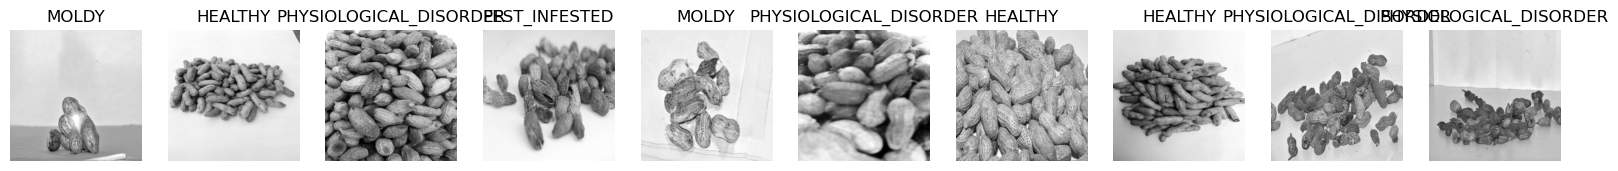

In [86]:
def plot_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(img_size), cmap='gray')
        axes[i].set_title(categories[labels[i]])
        axes[i].axis('off')
    plt.show()
    
plot_images(X_train, y_train)

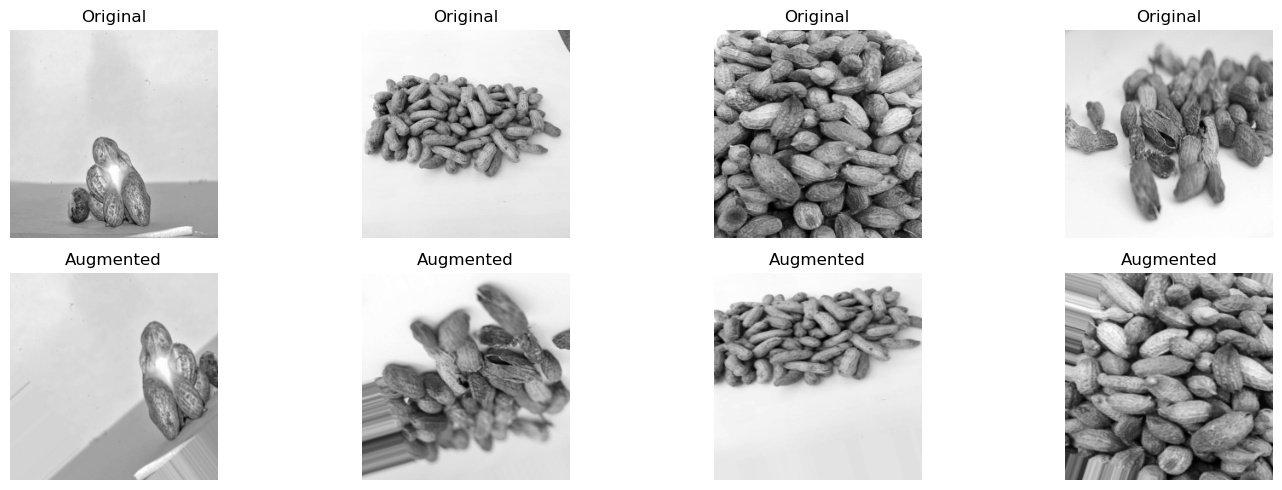

In [87]:
datagen = ImageDataGenerator(
    rotation_range=60,  # Random rotation in the range of 0-60 degrees
    width_shift_range=0.2,  # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=True,  # Random vertical flipping
    fill_mode='nearest'  
)

datagen.fit(X_train)

def plot_original_and_augmented(original_images, augmented_images, labels, num_images=4):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        axes[0, i].imshow(original_images[i].reshape(img_size), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(augmented_images[i].reshape(img_size), cmap='gray')
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


batch_size = 4  
num_augmented = 2  

augmented_generator = datagen.flow(X_train[:batch_size], y_train[:batch_size], batch_size=batch_size)

augmented_images, _ = next(augmented_generator)

plot_original_and_augmented(X_train[:batch_size], augmented_images, [y_train[0]] * batch_size)

In [88]:
num_train_samples = X_train.shape[0]
num_val_samples = X_val.shape[0]
num_test_samples = X_test.shape[0]

print("Number of samples in training set:", num_train_samples)
print("Number of samples in validation set:", num_val_samples)
print("Number of samples in testing set:", num_test_samples)

num_healthy_samples = np.sum(y_train == 0) + np.sum(y_val == 0) + np.sum(y_test == 0)
num_moldy_samples = np.sum(y_train == 1) + np.sum(y_val == 1) + np.sum(y_test == 1)
num_pest_infested_samples = np.sum(y_train == 2) + np.sum(y_val == 2) + np.sum(y_test == 2)
num_physiological_disorder_samples = np.sum(y_train == 3) + np.sum(y_val == 3) + np.sum(y_test == 3)

print("Number of HEALTHY samples:", num_healthy_samples)
print("Number of MOLDY samples:", num_moldy_samples)
print("Number of PEST_INFESTED samples:", num_pest_infested_samples)
print("Number of PHYSIOLOGICAL_DISORDER samples:", num_physiological_disorder_samples)

Number of samples in training set: 813
Number of samples in validation set: 204
Number of samples in testing set: 255
Number of HEALTHY samples: 364
Number of MOLDY samples: 363
Number of PEST_INFESTED samples: 291
Number of PHYSIOLOGICAL_DISORDER samples: 254


In [89]:
def count_samples_per_class(y):
    num_classes = np.max(y) + 1  
    class_counts = np.zeros(num_classes, dtype=int)
    for i in range(num_classes):
        class_counts[i] = np.sum(y == i)
    return class_counts

In [90]:
train_class_counts = count_samples_per_class(y_train)
print("Number of samples per class in training set:")
for i, count in enumerate(train_class_counts):
    print(f"Class {i} ({categories[i]}): {count}")

val_class_counts = count_samples_per_class(y_val)
print("\nNumber of samples per class in validation set:")
for i, count in enumerate(val_class_counts):
    print(f"Class {i} ({categories[i]}): {count}")

test_class_counts = count_samples_per_class(y_test)
print("\nNumber of samples per class in testing set:")
for i, count in enumerate(test_class_counts):
    print(f"Class {i} ({categories[i]}): {count}")


Number of samples per class in training set:
Class 0 (HEALTHY): 226
Class 1 (MOLDY): 236
Class 2 (PEST_INFESTED): 191
Class 3 (PHYSIOLOGICAL_DISORDER): 160

Number of samples per class in validation set:
Class 0 (HEALTHY): 50
Class 1 (MOLDY): 62
Class 2 (PEST_INFESTED): 46
Class 3 (PHYSIOLOGICAL_DISORDER): 46

Number of samples per class in testing set:
Class 0 (HEALTHY): 88
Class 1 (MOLDY): 65
Class 2 (PEST_INFESTED): 54
Class 3 (PHYSIOLOGICAL_DISORDER): 48


In [91]:
augmentation_percentages = [0.05, 0.3, 0.2, 0.3] 

augmented_train_data = []
augmented_train_labels = []

for class_id, augmentation_percentage in enumerate(augmentation_percentages):
    class_indices = np.where(y_train == class_id)[0]
    num_images_to_augment = int(augmentation_percentage * len(class_indices))
    
    indices_to_augment = np.random.choice(class_indices, num_images_to_augment, replace=False)
    
    for i in indices_to_augment:
        sample = X_train[i].reshape((1,) + X_train[i].shape)  
        augmented_samples = datagen.flow(sample, batch_size=1)
        for batch in augmented_samples:
            augmented_train_data.append(batch[0])
            augmented_train_labels.append(y_train[i])
            break  

augmented_train_data = np.array(augmented_train_data)
augmented_train_labels = np.array(augmented_train_labels)

X_train_augmented = np.concatenate((X_train, augmented_train_data))
y_train_augmented = np.concatenate((y_train, augmented_train_labels))

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

augmented_train_class_counts = count_samples_per_class(y_train_augmented)
print("Number of samples per class in augmented training set:")
for i, count in enumerate(augmented_train_class_counts):
    print(f"Class {i} ({categories[i]}): {count}")

Number of samples per class in augmented training set:
Class 0 (HEALTHY): 237
Class 1 (MOLDY): 306
Class 2 (PEST_INFESTED): 229
Class 3 (PHYSIOLOGICAL_DISORDER): 208


In [92]:
y_train_augmented = np.squeeze(y_train_augmented)
y_val = np.squeeze(y_val)

print(f"Shape of y_train_augmented after squeeze: {y_train_augmented.shape}")
print(f"Shape of y_val after squeeze: {y_val.shape}")

if len(y_train_augmented.shape) > 1 and y_train_augmented.shape[-1] != 4:
    y_train_augmented = np.squeeze(y_train_augmented)
if len(y_val.shape) > 1 and y_val.shape[-1] != 4:
    y_val = np.squeeze(y_val)

if y_train_augmented.ndim > 1 and y_train_augmented.shape[-1] == 4:
    y_train_augmented = np.argmax(y_train_augmented, axis=-1)
if y_val.ndim > 1 and y_val.shape[-1] == 4:
    y_val = np.argmax(y_val, axis=-1)

y_train_augmented = to_categorical(y_train_augmented, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

print(f"Shape of y_train_augmented after to_categorical: {y_train_augmented.shape}")
print(f"Shape of y_val after to_categorical: {y_val.shape}")

X_train_resized = np.array([cv2.resize(img, (256, 256)) for img in X_train_augmented])
X_val_resized = np.array([cv2.resize(img, (256, 256)) for img in X_val])
X_test_resized = np.array([cv2.resize(img, (256, 256)) for img in X_test])

X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

Shape of y_train_augmented after squeeze: (980,)
Shape of y_val after squeeze: (204,)
Shape of y_train_augmented after to_categorical: (980, 4)
Shape of y_val after to_categorical: (204, 4)


In [93]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_rgb, y_train_augmented, epochs=10, batch_size=32, validation_data=(X_val_rgb, y_val))

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.3852 - loss: 6.7415 - val_accuracy: 0.7206 - val_loss: 0.6957
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8292 - loss: 0.4432 - val_accuracy: 0.7892 - val_loss: 0.5247
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9142 - loss: 0.2151 - val_accuracy: 0.8627 - val_loss: 0.3705
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9818 - loss: 0.0893 - val_accuracy: 0.8873 - val_loss: 0.3795
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9768 - loss: 0.0951 - val_accuracy: 0.8529 - val_loss: 0.4019
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9963 - loss: 0.0425 - val_accuracy: 0.8971 - val_loss: 0.3164
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9998 - loss: 0.0246 - val_accuracy: 0.8725 - val_loss: 0.3503
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.8676 - val_lo

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


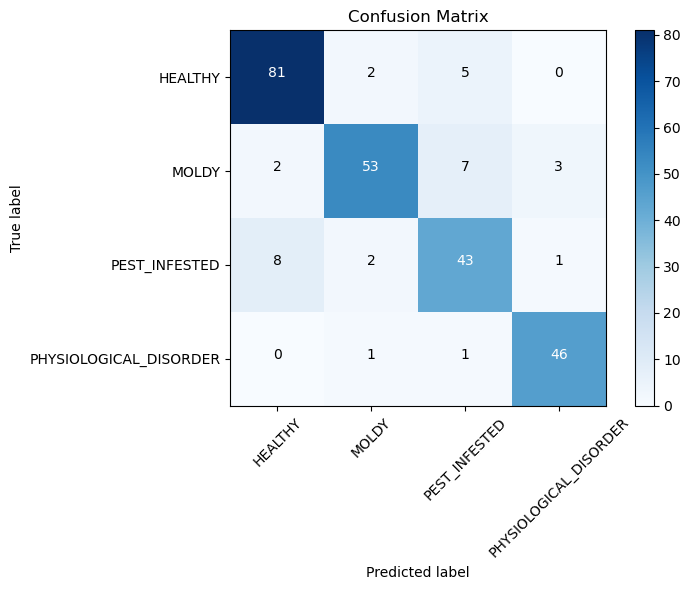

In [94]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["HEALTHY", "MOLDY", "PEST_INFESTED", "PHYSIOLOGICAL_DISORDER"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()


plt.show()

In [95]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 97.1014
Precision: 96.3636
Recall: 96.3636
F-Score: 96.3636


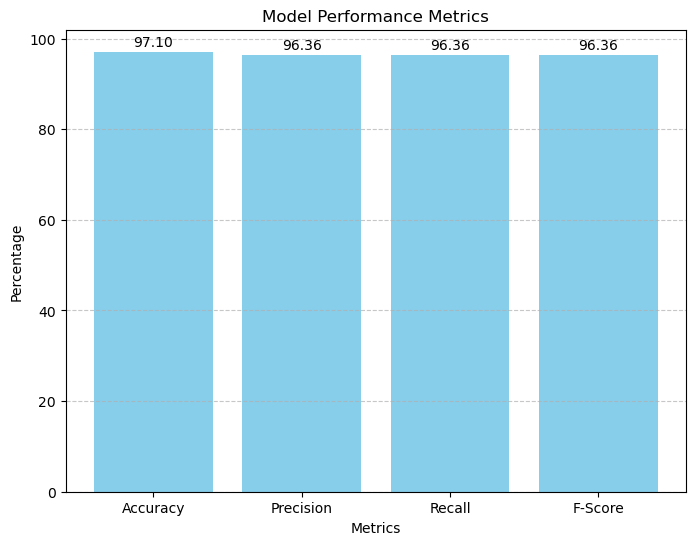

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


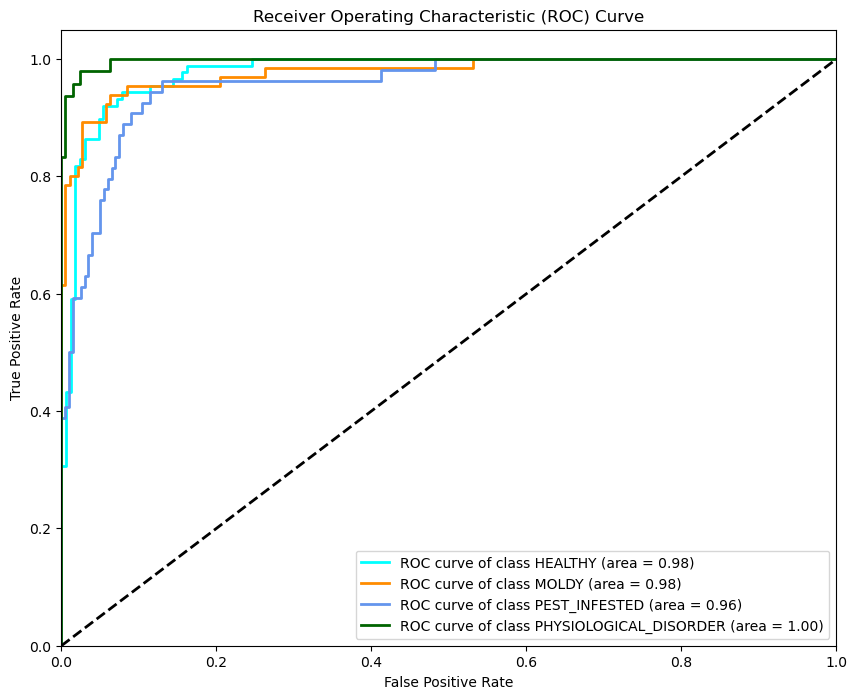

In [96]:
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

y_pred_probs = model.predict(X_test_rgb)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [99]:
inception_resnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in inception_resnet_v2.layers[:-10]:
    layer.trainable = False
for layer in inception_resnet_v2.layers[-10:]:
    layer.trainable = True

model = Sequential()
model.add(inception_resnet_v2)

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])


y_train_integers = np.argmax(y_train_augmented, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weights = dict(enumerate(class_weights))

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_rgb, 
    y_train_augmented, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_val_rgb, y_val), 
    class_weight=class_weights, 
    callbacks=[lr_scheduler]
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 943ms/step - accuracy: 0.4301 - loss: 0.7983 - precision_2: 0.4400 - recall_2: 0.3504 - val_accuracy: 0.5098 - val_loss: 0.6070 - val_precision_2: 0.6418 - val_recall_2: 0.4216 - learning_rate: 1.0000e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 830ms/step - accuracy: 0.6782 - loss: 0.5819 - precision_2: 0.7143 - recall_2: 0.6345 - val_accuracy: 0.6961 - val_loss: 0.4456 - val_precision_2: 0.8224 - val_recall_2: 0.6127 - learning_rate: 1.0000e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 52s 837ms/step - accuracy: 0.7454 - loss: 0.5146 - precision_2: 0.7782 - recall_2: 0.7110 - val_accuracy: 0.8088 - val_loss: 0.4080 - val_precision_2: 0.8343 - val_recall_2: 0.7157 - learning_rate: 1.0000e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 52s 840ms/step - accuracy: 0.8024 - loss: 0.4457 - precision_2: 0.8320 - recall_2: 0.7818 - val_accuracy: 0.8578 - val_loss: 0.3527 - val_precision_2: 0.8848 - val_recall_2: 0.8284 - learning_rate: 1.0000e-04
Epoch 5/50
6

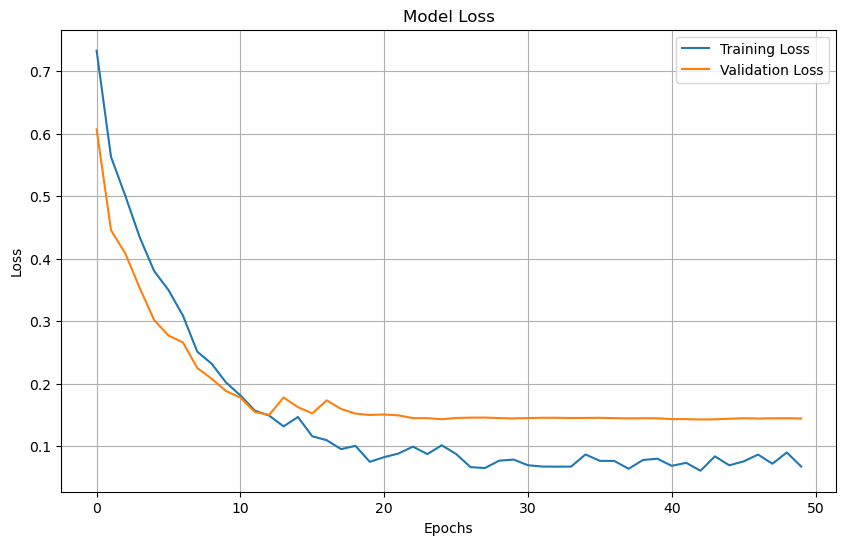

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

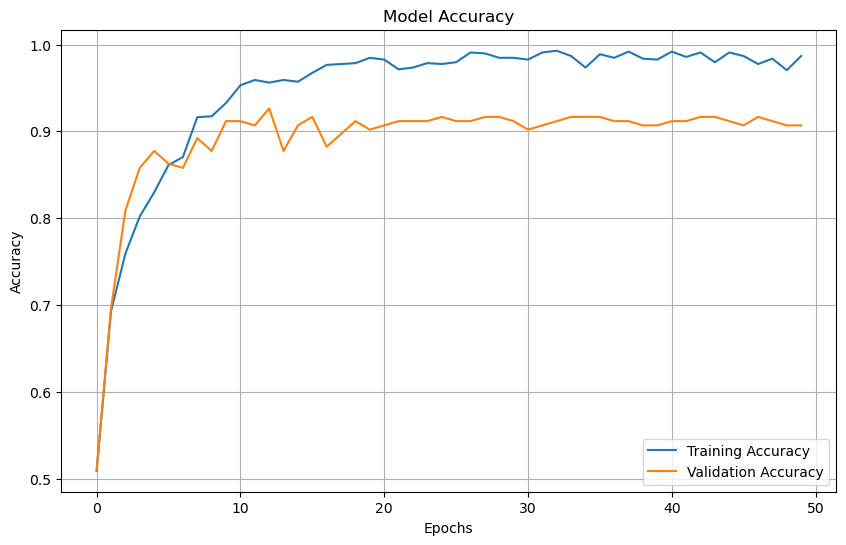

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


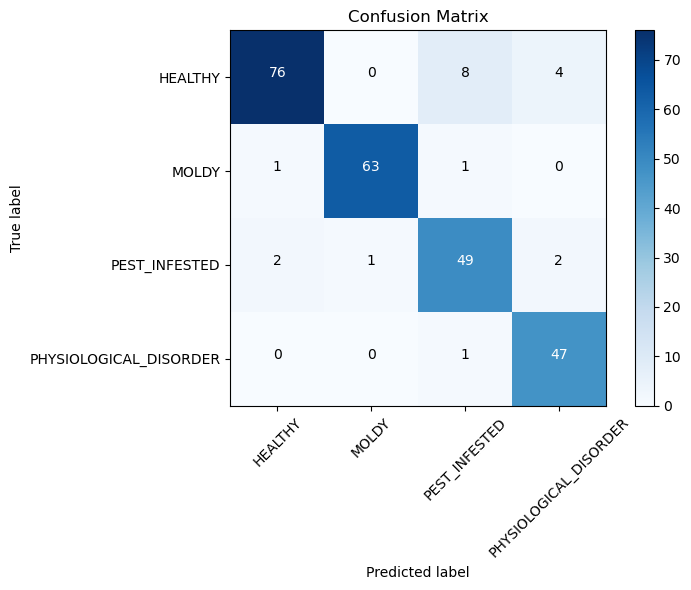

In [107]:

y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["HEALTHY", "MOLDY", "PEST_INFESTED", "PHYSIOLOGICAL_DISORDER"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

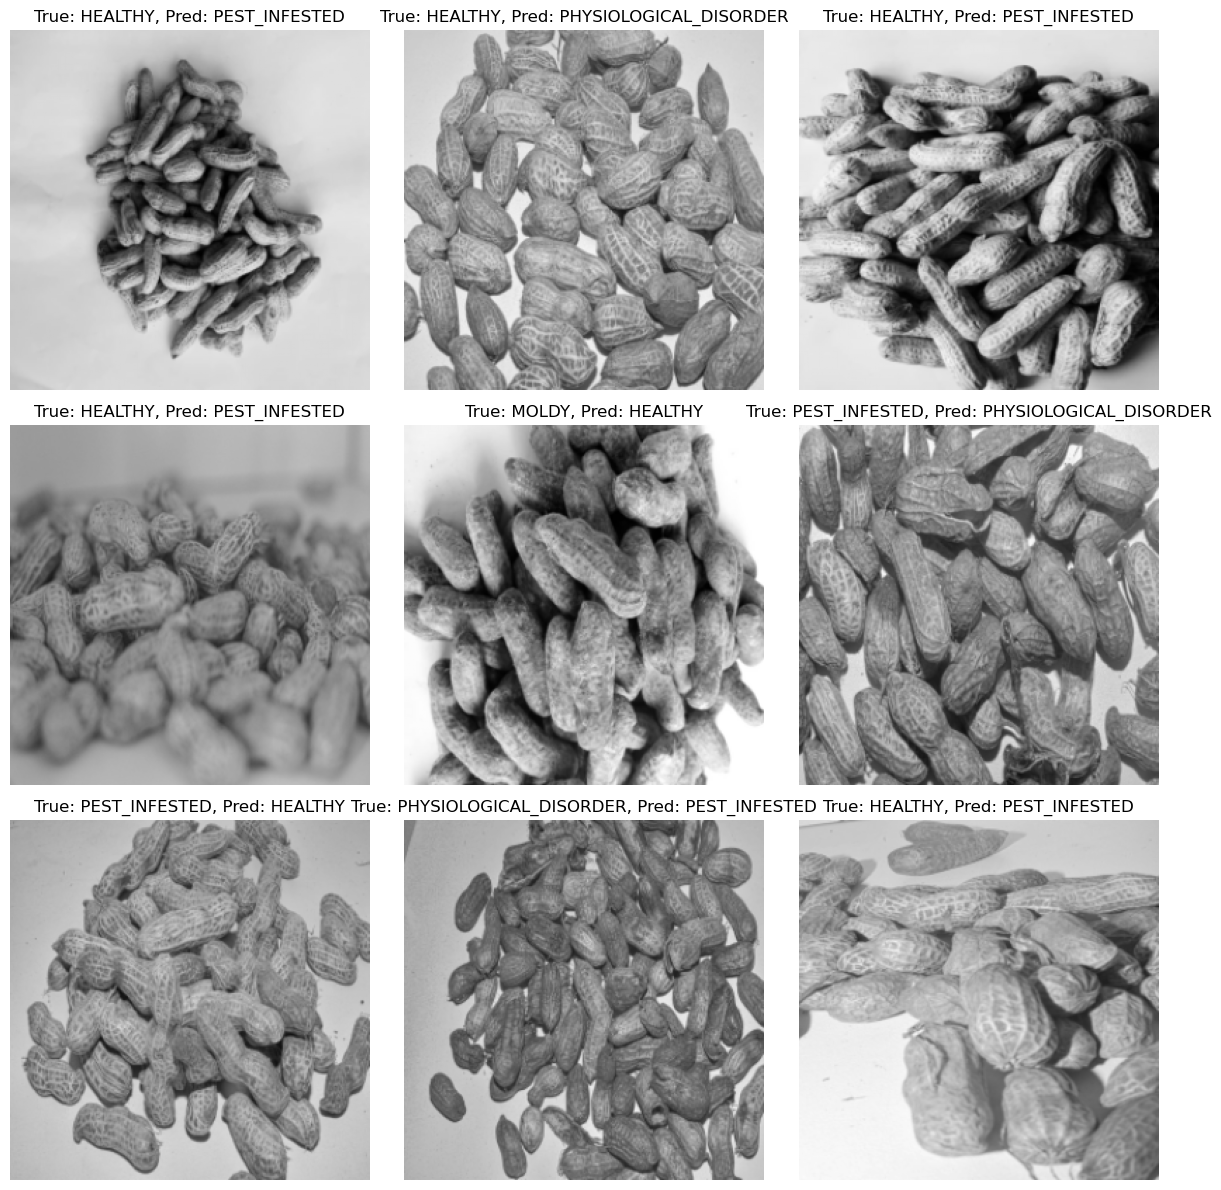

In [110]:
incorrect_indices = np.where(y_pred_classes != true_classes)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(random.sample(list(incorrect_indices), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_rgb[idx])
    plt.title(f'True: {categories[true_classes[idx]]}, Pred: {categories[y_pred_classes[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

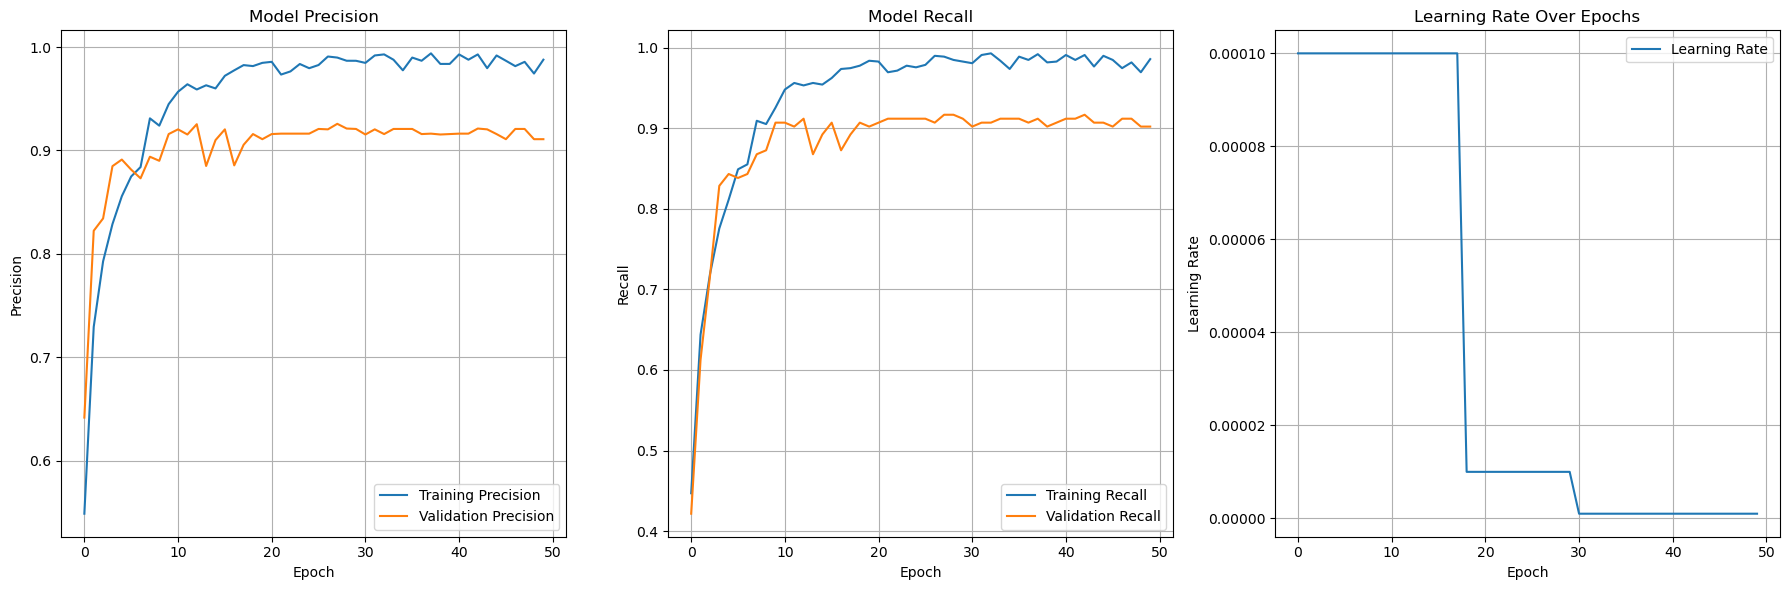

In [118]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['precision_2'], label='Training Precision')
plt.plot(history.history['val_precision_2'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['recall_2'], label='Training Recall')
plt.plot(history.history['val_recall_2'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [101]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 99.2857
Precision: 100.0
Recall: 98.4375
F-Score: 99.2126


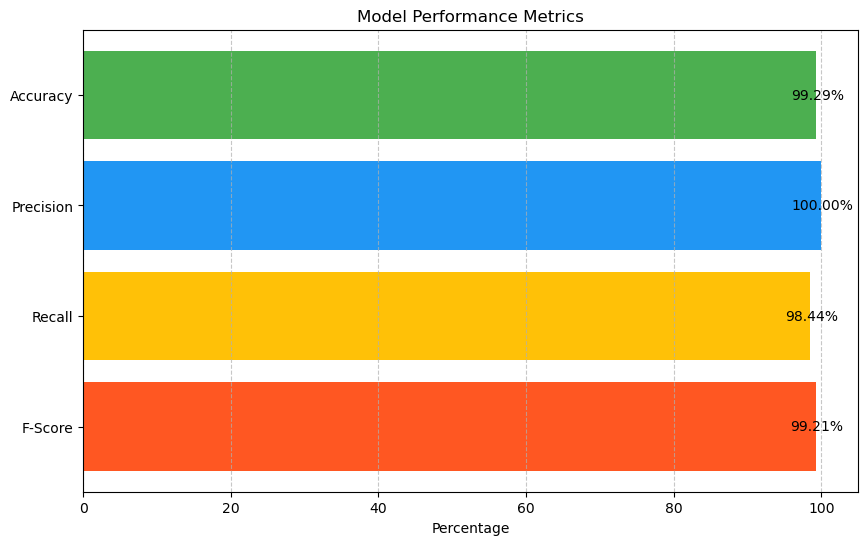

In [121]:
metrics = {
    'Accuracy': 99.2857,
    'Precision': 100.0,
    'Recall': 98.4375,
    'F-Score': 99.2126
}

labels = list(metrics.keys())
values = list(metrics.values())

# Create the horizontal bar graph
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, values, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722'])

# Invert y-axis to have the first metric on top
plt.gca().invert_yaxis()

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('Percentage')

# Annotate the bars with the metric values
for bar, value in zip(bars, values):
    plt.text(value + 0.2, bar.get_y() + bar.get_height()/2, f'{value:.2f}%', ha='center', va='center')

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


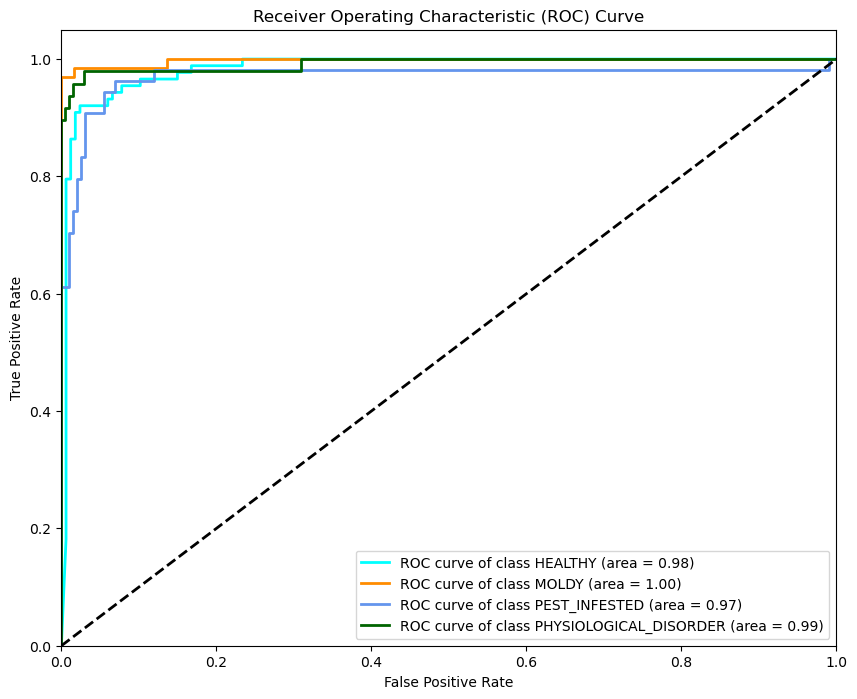

In [102]:
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

y_pred_probs = model.predict(X_test_rgb)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()